In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import time
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
import os;
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import confusion_matrix


In [14]:
# Define agent and algorithm for traversing the next node

class Agent:
    def __init__(self, start_node, end_node, color_preference):
        self.current_node = start_node
        self.color_preference = color_preference
        self.visited_nodes = set([start_node])
        self.visited_shapes = []  # List to store visited shapes
        self.visited_shininess = []  # List to store visited shininess
        self.start_node = start_node
        self.end_node = end_node

    def find_next_node(self, graph):
        neighboring_nodes = list(graph.neighbors(self.current_node))
        neighbors_with_preference = [
            node for node in neighboring_nodes
            if graph.nodes[node]['color'] == self.color_preference and node not in self.visited_nodes
        ]

        if neighbors_with_preference:
            # Find the neighbor that has the longest path (farthest from end_node)
            longest_path_node = max(
                neighbors_with_preference,
                key=lambda node: nx.shortest_path_length(graph, source=node, target=self.end_node)
            )
            return longest_path_node
        return None

    def traverse_graph(self, graph):
        path = [self.current_node]
        while self.current_node != self.end_node:
            next_node = self.find_next_node(graph)
            if next_node is None:
                break
            self.visited_nodes.add(next_node)
            path.append(next_node)
            self.current_node = next_node
            self.visited_shapes.append(graph.nodes[next_node]['shape'])
            self.visited_shininess.append(graph.nodes[next_node]['shiny'])
        return path, sum([1 for node in path if graph.nodes[node]['color'] == self.color_preference])

        # Calculate the number of nodes in the path that match the agent's color preference
#         preferred_color_count = sum(1 for node in path if graph.nodes[node]['color'] == self.color_preference)
        return path, preferred_color_count


In [15]:
# Define how the graph is structured, plot it and map nodes to colors
#Define how agents can simulate the traversals of the coloured graphs

def generate_colored_graph(num_nodes, colors, edge_probability, node_color_seed, edge_seed):
    G = nx.Graph()
    random.seed(node_color_seed)
    edge_random = random.Random(edge_seed)
    shapes = ['circle', 'square', 'triangle']
    shininess_options = ['shiny', 'not_shiny']

    for i in range(1, num_nodes + 1):
        color = random.choice(colors)
        shape = random.choice(shapes)
        shininess = random.choice(shininess_options)
        G.add_node(i, color=color, shape=shape, shiny=shininess)

    for i in range(1, num_nodes + 1):
        for j in range(i + 1, num_nodes + 1):
            if random.random() < edge_probability:
                G.add_edge(i, j)

    return G

def plot_colored_graph(G, seed):
    pos = nx.spring_layout(G, seed=42)
    colors = [G.nodes[node]['color'] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=500)
    nx.draw_networkx_edges(G, pos)
    plt.title(f"Graph for Seed {seed}")
    plt.axis('off')
    plt.show(block=False)  # Non-blocking display
    plt.pause(0.1)  # Allow a brief pause for rendering
    plt.clf()  # Clear the figure for the next plot
    plt.close()  # Explicitly close the plot

def map_nodes_to_colors(path, color_mapping):
    return [color_mapping[node] for node in path]

def simulate_agents(graph, num_agents, num_traversals, seed, min_distance=4):
    agent_data = []
    color_mapping = {node: graph.nodes[node]['color'] for node in graph.nodes()}  # Create color mapping for this graph
    
    # Precompute shortest path lengths between all node pairs
    shortest_paths = dict(nx.all_pairs_shortest_path_length(graph))

    for _ in range(num_traversals):
        for agent_id in range(num_agents):
            start_node, end_node = None, None

            while True:
                # Select a random start node
                start_node = random.choice(list(graph.nodes()))
                start_color = graph.nodes[start_node]['color']
                
                # Filter valid end nodes that have the same color
                valid_end_nodes = [n for n in graph.nodes() if graph.nodes[n]['color'] == start_color]
                
                # Randomly select an end node from the valid nodes
                end_node = random.choice(valid_end_nodes)

                # Ensure that the selected end node is far enough from the start node
                if shortest_paths[start_node][end_node] >= min_distance and start_node != end_node:
                    break

            # Choose a random color preference for the agent
            color_preference = random.choice(['green', 'red'])

            # Simulate the agent's traversal
            agent = Agent(start_node, end_node, color_preference)
            path, preferred_color_count = agent.traverse_graph(graph)

            # Store agent data
            agent_data.append({
                'Seed': seed,
                'Agent': agent_id,
                'Start Node': start_node,
                'End Node': end_node,
                'Color Preference': color_preference,
                'Path Length': len(path),
                'Preferred Color Count': preferred_color_count,
                'Path': path,
                'Mapped Colors': map_nodes_to_colors(path, color_mapping),
                'Visited Shapes': agent.visited_shapes,
                'Visited Shininess': agent.visited_shininess,
                'Density': edge_probability  # Ensure edge_probability is defined globally or passed in as a parameter
            })

    return pd.DataFrame(agent_data)


In [16]:
# Define the parameters and run the pipeline
results = []
num_nodes = 40  # Adjust as necessary
colors = ['green', 'red', 'blue']
edge_probability = 0.20  # Adjust as necessary

for seed in range(10):
    G = generate_colored_graph(num_nodes, colors, edge_probability, seed, seed + 1000)
    
    df_agents = simulate_agents(G, 4, 50, seed, min_distance=3)  # Simulate 5 agents, 10 traversals
    results.append(df_agents)

In [18]:
# Combine all results into a single DataFrame for analysis
full_results = pd.concat(results, ignore_index=True)

In [19]:
full_results.shape

(2000, 12)

In [20]:
#Get data with longer paths
full_results= full_results[full_results['Path Length'] > 4 ]


In [21]:
full_results.shape

(1118, 12)

In [22]:
# full_results[full_results["Color Preference"] == "yellow"]

In [23]:
# full_results.head()

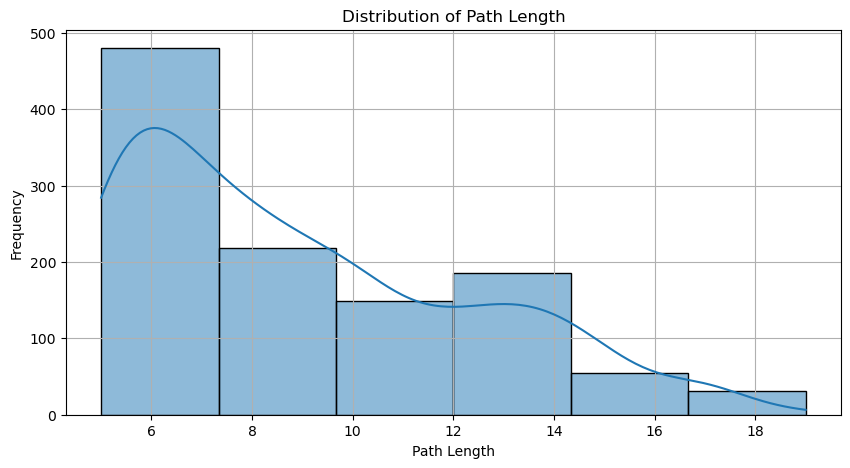

In [24]:
# Plotting the distribution of Path Length
plt.figure(figsize=(10, 5))
sns.histplot(full_results['Path Length'], bins=6, kde=True)
plt.title('Distribution of Path Length')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [25]:
full_results.shape

(1118, 12)

In [26]:
import networkx as nx
import matplotlib.pyplot as plt

def check_graph_connected(G):
    """Check if all nodes in the graph are connected.
    
    Returns:
        bool: True if the graph is connected, False otherwise.
    """
    return nx.is_connected(G)

def plot_connected_vs_density(edge_probabilities, connectivity_results):
    """Plot a graph of connectivity percentage vs. density (edge probability).
    
    Args:
        edge_probabilities (list): List of edge probabilities.
        connectivity_results (list): List of connectivity results (percentage of connected graphs).
    """
    plt.figure(figsize=(8, 5))
    plt.plot(edge_probabilities, connectivity_results, marker='o', linestyle='-', color='b')
    plt.xlabel('Edge Probability (Density)')
    plt.ylabel('Percentage of Connected Graphs')
    plt.title('Connected vs. Density')
    plt.grid(True)
    plt.xticks(edge_probabilities)  # Show ticks for each edge probability
    plt.tight_layout()
    plt.show()

def calculate_average_path_length(G):
    """Calculate the average path length if the graph is connected.
    
    Returns:
        float or None: The average path length if the graph is connected, None otherwise.
    """
    if check_graph_connected(G):
        return nx.average_shortest_path_length(G)
    return None

def plot_avg_path_length_vs_density(edge_probabilities, avg_path_lengths):
    """Plot a graph of average path length vs. density (edge probability).
    
    Args:
        edge_probabilities (list): List of edge probabilities.
        avg_path_lengths (list): List of average path lengths.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(edge_probabilities, avg_path_lengths, marker='o', linestyle='-', color='g')
    plt.xlabel('Edge Probability (Density)')
    plt.ylabel('Average Path Length')
    plt.title('Average Path Length vs. Density')
    plt.grid(True)
    plt.xticks(edge_probabilities)  # Show ticks for each edge probability
    plt.tight_layout()
    plt.show()


In [27]:
def verify_color_bias(df):
    # Calculate the proportion of preferred color nodes visited in each path
    df['Preferred_Color_Proportion'] = df['Preferred Color Count'] / df['Path Length']
    
    # Calculate the overall average proportion
    overall_average_proportion = df['Preferred_Color_Proportion'].mean()
    
    print("Overall Average Proportion of Preferred Color Nodes:", overall_average_proportion)

    # Expected proportion if there was no bias (assuming equal distribution of colors)
    expected_proportion = 1 / len(colors)
    print("Expected Proportion if No Bias:", expected_proportion)

    # Verify the paths are biased towards the preferred color
    if overall_average_proportion > expected_proportion:
        print("The paths are biased towards the preferred color.")
    else:
        print("The paths do not show a significant bias towards the preferred color.")

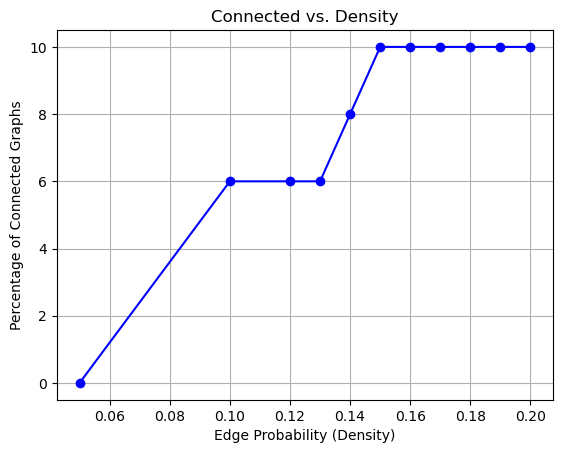

In [28]:
def check_graph_connected(G):
    """Check if all nodes in the graph are connected."""
    return nx.is_connected(G)

def plot_connected_vs_density(edge_probabilities, connectivity_results):
    """Plot a graph of connectivity percentage vs. density (edge probability)."""
    plt.plot(edge_probabilities, connectivity_results, marker='o', linestyle='-', color='b')
    plt.xlabel('Edge Probability (Density)')
    plt.ylabel('Percentage of Connected Graphs')
    plt.title('Connected vs. Density')
    plt.grid(True)
    plt.show()

num_nodes = 40
colors = ['green', 'red', 'blue']
#           , 'blue', 'yellow']
edge_probabilities = [0.05, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
connectivity_results = []

# Track connectivity for each edge probability
for edge_probability in edge_probabilities:
    connected_count = 0
    for seed in range(5):  # Iterate over 5 seeds for each density
        G = generate_colored_graph(num_nodes, colors, edge_probability, seed, seed + 100)
        
        # Check if the graph is connected
        if check_graph_connected(G):
            connected_count += 1
    
    # Calculate percentage of connected graphs for this density
    connectivity_percentage = (connected_count / 50) * 100
    connectivity_results.append(connectivity_percentage)

# Plot the results
plot_connected_vs_density(edge_probabilities, connectivity_results)


In [29]:
full_results.columns

Index(['Seed', 'Agent', 'Start Node', 'End Node', 'Color Preference',
       'Path Length', 'Preferred Color Count', 'Path', 'Mapped Colors',
       'Visited Shapes', 'Visited Shininess', 'Density'],
      dtype='object')

In [30]:
verify_color_bias(full_results)


Overall Average Proportion of Preferred Color Nodes: 0.9055288514120075
Expected Proportion if No Bias: 0.3333333333333333
The paths are biased towards the preferred color.


In [31]:
# full_results.head(20)

In [32]:
# This is for the clustering performance evaluation

def process_clustering_evals(df):
    df['Path_Set'] = df['Path'].apply(lambda x: set(x))
    
    def jaccard_distance(set1, set2):
        if len(set1.union(set2)) == 0:
            return 1  # Maximum distance if both sets are empty
        return 1 - len(set1.intersection(set2)) / len(set1.union(set2))

    results = []
    linkage_methods = ['ward']
    n_clusters = 3

    for seed, group in df.groupby('Seed'):
        group = group.copy()  # Work with a copy to avoid side effects
        distance_matrix = np.zeros((len(group), len(group)))
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                distance_matrix[i, j] = jaccard_distance(group.iloc[i]['Path_Set'], group.iloc[j]['Path_Set'])
                distance_matrix[j, i] = distance_matrix[i, j]

        distance_array = squareform(distance_matrix)

        for method in linkage_methods:
            Z = linkage(distance_array, method=method)
            clusters = fcluster(Z, t=n_clusters, criterion='maxclust')
            group['Cluster'] = clusters 

            # Calculate accuracy
            group['Accuracy'] = group.apply(lambda row: row['Mapped Colors'].count(row['Color Preference']) / len(row['Mapped Colors']) if len(row['Mapped Colors']) > 0 else 0, axis=1)

            # Correctly handle the explosion of colors
            exploded_group = group.explode('Mapped Colors')
            exploded_group.rename(columns={'Mapped Colors': 'Flat Colors'}, inplace=True)

            # Compute color counts per cluster
            color_counts = exploded_group.groupby(['Cluster', 'Flat Colors']).size().unstack(fill_value=0)
            color_percentages = color_counts.div(color_counts.sum(axis=1), axis=0).mul(100).round(2)

            # Format the color percentages for output
            cluster_color_percentages = color_percentages.apply(lambda x: x.dropna().to_dict(), axis=1).to_dict()
            formatted_cluster_color_percentages = {k: {color: f"{percent}%" for color, percent in v.items()} for k, v in cluster_color_percentages.items()}

            # Calculate maximum color separation for each cluster and take the maximum
            max_color_separation = color_percentages.apply(lambda x: max(x) - min(x) if len(x) > 1 else 0).max()

            # Calculate the silhouette score 
            silhouette_avg = -1
            if len(set(clusters)) > 1:
                silhouette_avg = silhouette_score(distance_matrix, clusters, metric='precomputed')

            # Calculate average accuracy per cluster
            avg_accuracy = group['Accuracy'].mean()

            results.append({
                'Seed': seed,
                'Linkage Method': method,
                'Cluster Color Percentage': formatted_cluster_color_percentages,
                'Silhouette Score': silhouette_avg,
                'Maximum Color Separation': max_color_separation,
                'Average Accuracy': avg_accuracy  # Store average accuracy for the clustering
            })

    return pd.DataFrame(results), group

In [33]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
# Import necessary metrics from sklearn
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# --- Helper Function 
def jaccard_distance(set1, set2):
    """Calculates the Jaccard distance between two sets."""
    set1 = set(set1) # Ensure inputs are sets
    set2 = set(set2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 1.0  # Distance is 1 if both sets are empty
    return 1.0 - intersection / union

# --- Modified Evaluation Function ---
def process_and_evaluate_clustering(df, n_clusters=4): # Renamed and added n_clusters param
    """
    Performs hierarchical clustering based on Jaccard distance of Path_Set
    for each seed and evaluates clustering using standard metrics against Color Preference.

    Args:
        df (pd.DataFrame): DataFrame with simulation results, must include
                           'Path', 'Seed', 'Color Preference', 'Mapped Colors'.
        n_clusters (int): The number of clusters to form.

    Returns:
        tuple: (pd.DataFrame, pd.DataFrame)
            - results_summary_df: DataFrame summarizing metrics per seed.
            - df_with_clusters: Original DataFrame with 'Cluster' assignments added for all seeds.
    """
    # --- Input Validation ---
    required_cols = ['Path', 'Seed', 'Color Preference', 'Mapped Colors']
    if not all(col in df.columns for col in required_cols):
         raise ValueError(f"Input DataFrame must contain columns: {required_cols}")

    print(f"Processing clustering with n_clusters={n_clusters}...")

    # --- Feature Engineering ---
    # 'Path' is treated as a list/tuple before creating set
    df['Path_Set'] = df['Path'].apply(lambda x: set(x) if isinstance(x, (list, tuple)) else set())

    results_summary = []
    processed_groups = [] # To store groups with cluster assignments added
    linkage_methods = ['ward'] # Currently only using ward

    # --- Loop through each simulation run ---
    for seed, group in df.groupby('Seed'):
        print(f" Processing Seed {seed}...")
        group = group.copy()
        num_samples = len(group)

        if num_samples < 2:
            print(f"  Skipping Seed {seed}: Not enough samples ({num_samples}) for distance calculation.")
            group['Cluster'] = 1 # Assign dummy cluster if only 1 sample
            processed_groups.append(group)
            # Optionally append default/NaN values to results_summary or just skip
            continue

        # --- Calculate Distance Matrix ---
        distance_matrix = np.zeros((num_samples, num_samples))
        path_sets = group['Path_Set'].tolist() 
        valid_matrix = True
        for i in range(num_samples):
            for j in range(i + 1, num_samples):
                try:
                    dist = jaccard_distance(path_sets[i], path_sets[j])
                    if not np.isfinite(dist): # Check for NaN/inf
                         print(f"  Warning: Invalid Jaccard distance ({dist}) between samples {i} and {j} in Seed {seed}. Skipping seed.")
                         valid_matrix = False
                         break
                    distance_matrix[i, j] = dist
                    distance_matrix[j, i] = dist
                except Exception as e:
                    print(f"  Error calculating Jaccard for samples {i}, {j} in Seed {seed}: {e}. Skipping seed.")
                    valid_matrix = False
                    break
            if not valid_matrix: break
        
        if not valid_matrix:
             processed_groups.append(group) # Append group even if clustering fails
             continue

        # Convert to condensed form for linkage
        try:
             # Use checks=False initially; linkage will often handle minor precision issues
             distance_array = squareform(distance_matrix, checks=False)
        except ValueError as e:
             print(f"  Warning: Skipping Seed {seed} due to distance matrix issue for squareform: {e}")
             processed_groups.append(group)
             continue


        # --- Perform Clustering ---
        for method in linkage_methods:
            try:
                Z = linkage(distance_array, method=method)
                # Ensure n_clusters is not more than num_samples
                actual_n_clusters = min(n_clusters, num_samples)
                if actual_n_clusters < 1: actual_n_clusters = 1

                clusters = fcluster(Z, t=actual_n_clusters, criterion='maxclust')
                group['Cluster'] = clusters
                num_unique_clusters_found = len(set(clusters))

                # --- Evaluate Clustering ---
                silhouette_avg = np.nan # Default to NaN
                ari_score = np.nan
                nmi_score = np.nan

                # Silhouette requires at least 2 distinct clusters and less than N clusters
                if num_unique_clusters_found > 1 and num_unique_clusters_found < num_samples:
                    try:
                         silhouette_avg = silhouette_score(distance_matrix, clusters, metric='precomputed')
                    except ValueError as e:
                         print(f"   Warning: Could not compute Silhouette Score for Seed {seed}: {e}")

                # Ground truth evaluation metrics (ARI, NMI)
                try:
                    ari_score = adjusted_rand_score(group['Color Preference'], group['Cluster'])
                    nmi_score = normalized_mutual_info_score(group['Color Preference'], group['Cluster'])
                except ValueError as e:
                     print(f"   Warning: Could not compute ARI/NMI for Seed {seed}: {e}")


                # --- Calculate Cluster Color Purity 
                formatted_cluster_color_percentages = {}
                max_color_separation = np.nan
                try:
                    exploded_group = group.explode('Mapped Colors')
                    # Handle potential non-string values if necessary before rename
                    exploded_group = exploded_group.dropna(subset=['Mapped Colors'])
                    exploded_group.rename(columns={'Mapped Colors': 'Flat Colors'}, inplace=True)

                    color_counts = exploded_group.groupby(['Cluster', 'Flat Colors']).size().unstack(fill_value=0)

                    # Ensure all expected colors (from simulation setup) are columns
                    all_possible_colors = df['Color Preference'].unique() # Base on overall ground truth
                    for color in all_possible_colors:
                        if color not in color_counts.columns:
                            color_counts[color] = 0
                    color_counts = color_counts[sorted(all_possible_colors)] # Consistent column order

                    cluster_sums = color_counts.sum(axis=1)
                    safe_sums = cluster_sums.replace(0, 1) # Avoid division by zero for empty clusters
                    color_percentages = color_counts.div(safe_sums, axis=0).mul(100).round(2)

                    cluster_color_percentages = color_percentages.apply(lambda row: row.dropna().to_dict(), axis=1).to_dict()
                    formatted_cluster_color_percentages = {
                        int(k): {color: f"{percent:.2f}%" for color, percent in v.items()}
                        for k, v in cluster_color_percentages.items()
                    } # Ensures keys are int, format percent

                    # Max separation calc (can be sensitive to outliers/small percentages)
                    max_color_separation = color_percentages.apply(lambda row: row.max() - row.min() if not row.empty else 0.0, axis=1).max()

                except Exception as e:
                    print(f"   Warning: Could not calculate color percentages for Seed {seed}: {e}")


                # --- Append Results Summary ---
                results_summary.append({
                    'Seed': seed,
                    'Linkage Method': method,
                    'Num Clusters': actual_n_clusters, # Store actual number used
                 
                    'Cluster Color Percentage': formatted_cluster_color_percentages,
                    'Silhouette Score': silhouette_avg,
                    'Adjusted Rand Index (ARI)': ari_score, #  compares Cluster vs Color Preference
                    'Normalized Mutual Info (NMI)': nmi_score, # compares Cluster vs Color Preference
                    'Maximum Color Separation': max_color_separation, # Original metric
                  
                })

            except Exception as e:
                print(f"  Error during clustering/evaluation for Seed {seed}, Method {method}: {e}")
               
                if 'Cluster' not in group.columns: # Ensure Cluster column exists even on error
                     group['Cluster'] = -1 # Assign error cluster

        processed_groups.append(group) # Store the group DataFrame with cluster assignments

    if not processed_groups: # Handle case where loop didn't run or all seeds failed early
        return pd.DataFrame(results_summary), df.copy() # Return empty summary and original df copy

    # --- Combine results ---
    df_with_clusters = pd.concat(processed_groups).reset_index(drop=True)
    results_summary_df = pd.DataFrame(results_summary)

    print("Clustering evaluation complete.")
    return results_summary_df, df_with_clusters

In [34]:
clusters_results, clusters_data=process_and_evaluate_clustering(full_results)

Processing clustering with n_clusters=4...
 Processing Seed 0...
 Processing Seed 1...
 Processing Seed 2...
 Processing Seed 3...
 Processing Seed 4...
 Processing Seed 5...
 Processing Seed 6...
 Processing Seed 7...
 Processing Seed 8...
 Processing Seed 9...
Clustering evaluation complete.


In [35]:



clusters_results.head(20)

,Seed,Linkage Method,Num Clusters,Cluster Color Percentage,Silhouette Score,Adjusted Rand Index (ARI),Normalized Mutual Info (NMI),Maximum Color Separation
0,0,ward,4,"{1: {'green': '10.09%', 'red': '89.91%'}, 2: {...",0.292644,0.000000,0.000000,90.72
1,1,ward,4,"{1: {'green': '86.96%', 'red': '13.04%'}, 2: {...",0.401219,0.597519,0.704186,96.62
2,2,ward,4,"{1: {'green': '2.91%', 'red': '97.09%'}, 2: {'...",0.271083,0.000000,0.000000,100.00
3,3,ward,4,"{1: {'green': '17.81%', 'red': '82.19%'}, 2: {...",0.482118,0.368196,0.590433,91.12
4,4,ward,4,"{1: {'green': '91.11%', 'red': '8.89%'}, 2: {'...",0.340276,0.725095,0.735959,93.68
5,5,ward,4,"{1: {'green': '98.15%', 'red': '1.85%'}, 2: {'...",0.284392,0.531136,0.679547,96.30
6,6,ward,4,"{1: {'green': '14.46%', 'red': '85.54%'}, 2: {...",0.304105,0.293323,0.516471,97.08
7,7,ward,4,"{1: {'green': '86.27%', 'red': '13.73%'}, 2: {...",0.371193,0.620460,0.709975,92.38
8,8,ward,4,"{1: {'green': '100.00%', 'red': '0.00%'}, 2: {...",0.477578,0.499130,0.663898,100.00
9,9,ward,4,"{1: {'green': '96.32%', 'red': '3.68%'}, 2: {'...",0.342825,0.499362,0.664666,97.28


In [36]:
clusters_results.to_csv('cluster_results_4colors')

In [37]:
clusters_data.shape

(1118, 15)

In [38]:
clusters_data.head()

,Seed,Agent,Start Node,End Node,Color Preference,Path Length,Preferred Color Count,Path,Mapped Colors,Visited Shapes,Visited Shininess,Density,Preferred_Color_Proportion,Path_Set,Cluster
0,0,1,17,32,red,10,9,"[17, 4, 30, 11, 3, 1, 23, 27, 8, 28]","[green, red, red, red, red, red, red, red, red...","[triangle, circle, square, square, square, tri...","[shiny, shiny, shiny, not_shiny, shiny, not_sh...",0.2,0.900000,"{1, 3, 4, 8, 11, 17, 23, 27, 28, 30}",2
1,0,2,18,7,red,9,8,"[18, 28, 8, 1, 3, 2, 30, 4, 37]","[blue, red, red, red, red, red, red, red, red]","[circle, circle, square, square, triangle, cir...","[shiny, shiny, shiny, not_shiny, not_shiny, sh...",0.2,0.888889,"{1, 2, 3, 4, 37, 8, 18, 28, 30}",3
2,0,3,34,19,red,9,8,"[34, 23, 11, 1, 3, 2, 30, 4, 37]","[blue, red, red, red, red, red, red, red, red]","[triangle, square, square, square, triangle, c...","[not_shiny, shiny, shiny, not_shiny, not_shiny...",0.2,0.888889,"{1, 34, 3, 2, 4, 37, 11, 23, 30}",3
3,0,3,21,17,red,10,9,"[21, 27, 1, 3, 2, 30, 11, 23, 8, 28]","[green, red, red, red, red, red, red, red, red...","[triangle, square, square, triangle, circle, s...","[shiny, shiny, not_shiny, not_shiny, shiny, sh...",0.2,0.900000,"{1, 2, 3, 8, 11, 21, 23, 27, 28, 30}",2
4,0,2,6,20,red,7,6,"[6, 8, 1, 11, 3, 23, 27]","[green, red, red, red, red, red, red]","[circle, square, square, square, triangle, tri...","[shiny, shiny, shiny, not_shiny, not_shiny, sh...",0.2,0.857143,"{1, 3, 6, 8, 11, 23, 27}",1


In [39]:
# clusters_data[clusters_data['Cluster'] == 2 ]

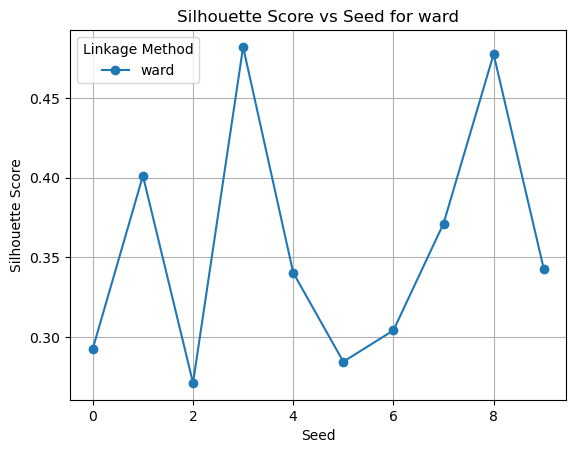

In [40]:
# Create a DataFrame
df = clusters_results.copy()

# Pivot the table to have Linkage Methods as columns and Seeds as rows
pivot_table = df.pivot(index='Seed', columns='Linkage Method', values='Silhouette Score')

# Plot the Silhouette scores for each linkage method
pivot_table.plot(kind='line', marker='o')

# Set the labels and title
plt.xlabel('Seed')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Seed for ward')
plt.grid(True)

# Show the plot
plt.show()


Using Color Mapping: {'green': 1, 'red': 2}
Matrix will be based on numeric labels: [1, 2]


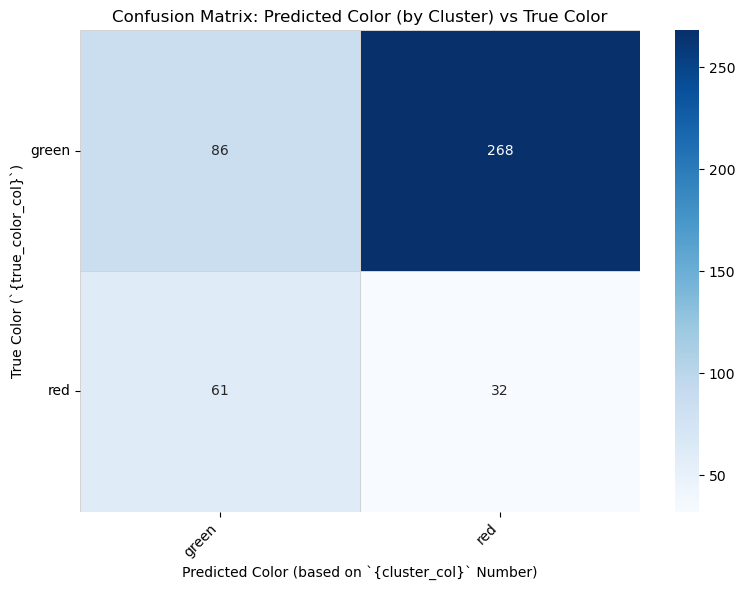

In [41]:
def plot_color_confusion_matrix(df, cluster_col='Cluster', true_color_col='Color Preference', figsize=(8, 6), cmap='Blues'):
    """
    Calculates and plots a confusion matrix comparing cluster assignments
    (predictions) against true color labels from the provided DataFrame.

    The matrix dimensions and axes are strictly based on the unique colors found
    in the `true_color_col`. Cluster numbers (predictions) that do not numerically
    correspond to any of the mapped colors are IGNORED in the matrix calculation.
    Assumes cluster number 'k' is intended to predict the color mapped to 'k'.

    Args:
        df (pd.DataFrame): DataFrame containing cluster assignments and true color labels.
                           Assumed to have one row per data point/instance.
        cluster_col (str): Name of the column containing cluster labels (predictions).
                           Must contain numeric labels (e.g., 1, 2, 3...).
        true_color_col (str): Name of the column containing the true color labels (e.g., 'green', 'red').
        figsize (tuple): Figure size (width, height) in inches. Defaults to (8, 6).
        cmap (str or matplotlib Colormap): Colormap for the heatmap. Defaults to "Blues".
                                           Seaborn handles automatic color scaling.
    """
    # --- Input Validation ---
    if cluster_col not in df.columns:
        raise ValueError(f"Cluster column '{cluster_col}' not found in DataFrame.")
    if true_color_col not in df.columns:
        raise ValueError(f"True color column '{true_color_col}' not found in DataFrame.")
    if not pd.api.types.is_numeric_dtype(df[cluster_col]):
         # Attempt conversion if possible, otherwise raise error
         try:
             df[cluster_col] = pd.to_numeric(df[cluster_col])
             print(f"Warning: Column '{cluster_col}' converted to numeric.")
         except (ValueError, TypeError):
             raise TypeError(f"Cluster column '{cluster_col}' must be numeric or convertible to numeric.")

    # --- 1. Dynamic Color Label Mapping ---
    # Get unique true color labels and sort them for consistent mapping order
    unique_colors = sorted(df[true_color_col].dropna().unique()) # Drop NA before getting unique
    if not unique_colors:
        print(f"Error: No valid unique values found in the true color column '{true_color_col}'.")
        return

    # Create mapping: color -> integer (e.g., {'green': 1, 'red': 2})
    # Starts from 1 for consistency. If your clusters naturally start from 0, adjust accordingly.
    color_to_int_mapping = {color: i + 1 for i, color in enumerate(unique_colors)}
    mapped_color_ints = list(color_to_int_mapping.values())  # e.g., [1, 2]
    mapped_color_names = list(color_to_int_mapping.keys())  # e.g., ['green', 'red']

    print(f"Using Color Mapping: {color_to_int_mapping}")
    print(f"Matrix will be based on numeric labels: {mapped_color_ints}")

    # --- 2. Prepare y_true and y_pred ---
    try:
        # Convert true color labels to numerical using the dynamic mapping
        y_true = df[true_color_col].map(color_to_int_mapping)
        # Use cluster assignments directly as predictions (ensure integer type)
        y_pred = df[cluster_col].astype(int) # Assuming cluster numbers are intended predictions
    except Exception as e:
        raise TypeError(f"Failed to convert labels/clusters to numeric types. Check columns '{true_color_col}' and '{cluster_col}'. Error: {e}")

    # Ensure alignment and handle potential NaNs from mapping `true_color_col`
    valid_indices = y_true.notna()
    if not valid_indices.all():
        print(f"Warning: {len(y_true) - valid_indices.sum()} entries in '{true_color_col}' "
              f"were invalid or not in {mapped_color_names}. Excluding these samples.")
        y_true = y_true[valid_indices].astype(int)
        y_pred = y_pred[valid_indices] # Keep y_pred aligned

    if len(y_true) == 0:
        print("Error: No valid samples remaining after mapping and filtering true labels.")
        return

    # --- 3. Calculate Confusion Matrix (Strictly Based on Mapped Colors) ---
    # KEY: Use 'labels=mapped_color_ints' to restrict the matrix dimensions and counts.
    # Predictions (cluster numbers) not in 'mapped_color_ints' are ignored by confusion_matrix.
    conf_matrix = confusion_matrix(y_true, y_pred, labels=mapped_color_ints)

    # --- 4. Prepare DataFrame for Plotting ---
    # Use the color names corresponding to mapped_color_ints for axes
    conf_matrix_df = pd.DataFrame(conf_matrix,
                                  index=mapped_color_names,   # Rows: True Colors
                                  columns=mapped_color_names) # Columns: Predicted Colors

    # --- 5. Visualize the Confusion Matrix ---
    plt.figure(figsize=figsize)
    sns.heatmap(conf_matrix_df,
                annot=True,      # Show counts in cells
                fmt='d',         # Format counts as integers
                cmap=cmap,       # Use the specified colormap ('Blues') - auto-scaled by seaborn
                cbar=True,       # Show the color bar
                linewidths=.5,
                linecolor='lightgray')

    plt.title(f'Confusion Matrix: Predicted Color (by Cluster) vs True Color')
    plt.ylabel('True Color (`{true_color_col}`)')
    plt.xlabel('Predicted Color (based on `{cluster_col}` Number)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
# Assuming your DataFrame is loaded into a variable named 'cluster_results_df'
try:
    # Create a copy to avoid modifying original DataFrame if needed
    df_to_plot = clusters_data.copy()

    # Call the function using the correct column names from your dataset
    plot_color_confusion_matrix(df_to_plot,
                                cluster_col='Cluster',              # Your cluster column name
                                true_color_col='Color Preference') # Your true color column name

except NameError:
    print("\nError: DataFrame 'cluster_results_df' not found.")
    print("Please load your data into a DataFrame with that name or update the variable name.")
    # You can add dummy data here for testing if needed
except Exception as e:
    print(f"An error occurred: {e}")

In [122]:
conf_matrix_df

,green,red
green,100,0
red,0,36


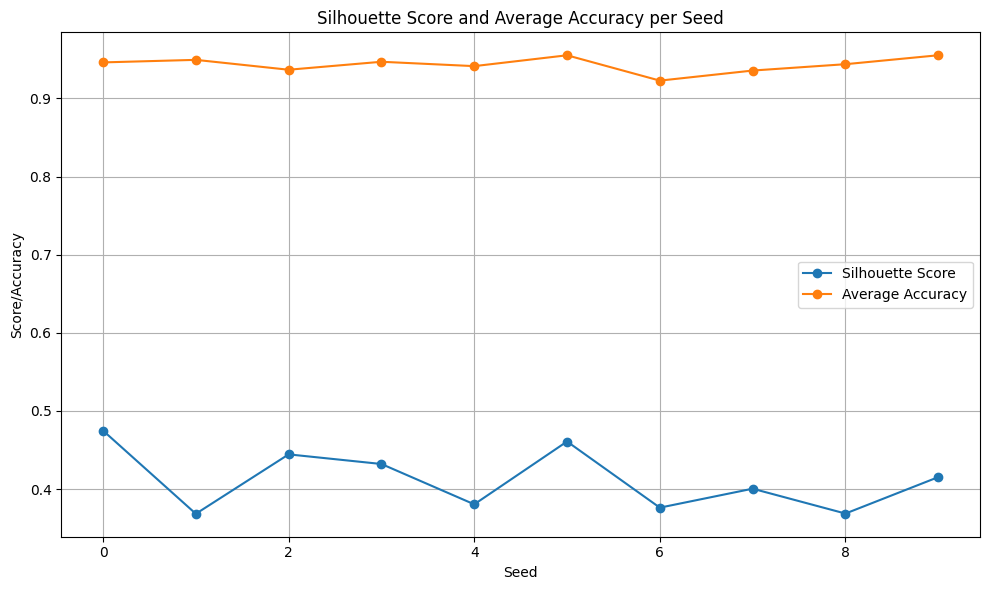

In [150]:
df = pd.DataFrame(clusters_results.copy())

# Plotting both Silhouette Score and Average Accuracy per seed
plt.figure(figsize=(10, 6))

# Plot Silhouette Score
plt.plot(df['Seed'], df['Silhouette Score'], marker='o', label='Silhouette Score')

# Plot Average Accuracy
plt.plot(df['Seed'], df['Average Accuracy'], marker='o', label='Average Accuracy')

# Adding labels, title, and legend
plt.title('Silhouette Score and Average Accuracy per Seed')
plt.xlabel('Seed')
plt.ylabel('Score/Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [151]:
def dominant_color_per_cluster(df, cluster_col='Cluster', color_col='Color Preference'): 
    # Group by the cluster and count occurrences of each color within the cluster
    color_counts = df.groupby([cluster_col, color_col]).size().unstack(fill_value=0)
    
    # Check the color counts to ensure correct grouping
    print("Color Counts per Cluster:")
    print(color_counts)  # Add this for debugging purposes

    # Find the dominant color in each cluster
    dominant_colors = color_counts.idxmax(axis=1)
    
    # Find the percentage of the dominant color in each cluster
    dominant_color_percentages = color_counts.max(axis=1) / color_counts.sum(axis=1) * 100
    
    # Combine the results in a DataFrame
    results = pd.DataFrame({
        'Cluster': color_counts.index,  # Adding this to ensure Cluster is properly tracked
        'Dominant Color': dominant_colors,
        'Dominant Color Percentage': dominant_color_percentages.round(2)
    }).reset_index(drop=True)  # Reset index to avoid keeping the 'Cluster' as an index
    
    # Debugging output for better understanding
    print("Dominant Color Results:")
    print(results)
    
    return results


In [152]:
dominant_color_per_cluster(clusters_data)

Color Counts per Cluster:
Color Preference  green  red
Cluster                     
1                    75    0
2                     0   88
Dominant Color Results:
   Cluster Dominant Color  Dominant Color Percentage
0        1          green                      100.0
1        2            red                      100.0


,Cluster,Dominant Color,Dominant Color Percentage
0,1,green,100.0
1,2,red,100.0


In [ ]:
# Confusion Matrix 

In [77]:
# result_df[result_df['Silhouette Score'] < 0]

In [153]:
# create the accuracy measure 
df = result_df
df = df[df["Silhouette Score"] != -1]
# Pivoting the data so each method gets its own line on the plot
methods = df['Linkage Method'].unique()

plt.figure(figsize=(10, 6))

# Plot each linkage method as a line
for method in methods:
    subset = df[df['Linkage Method'] == method]
    plt.plot(subset['Silhouette Score'], subset['Average Accuracy'], label=method, marker='o')

# Adding labels and title
plt.xlabel('Silhouette Score')
plt.ylabel('Average Accuracy')
plt.title('Accuracy vs Silhouette Score by Linkage Method')

# Show the legend, grid, and plot
plt.legend(title="Linkage Method")
plt.grid(True)
plt.show()

NameError: name 'result_df' is not defined

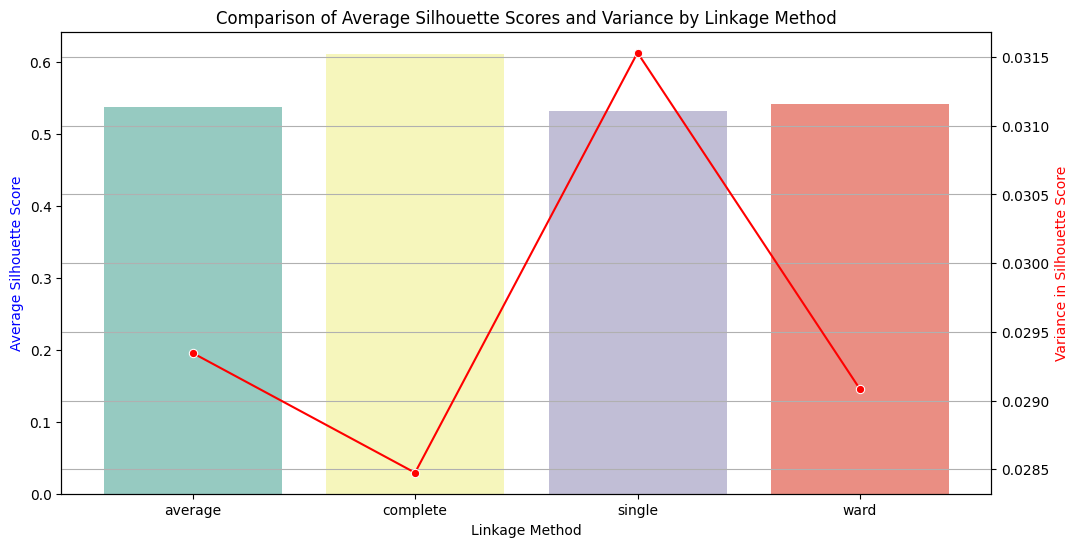

In [57]:
data=result_df
df = pd.DataFrame(data)

# Filter out the invalid silhouette scores
df = df[df["Silhouette Score"] != -1]

# Group by Linkage Method and calculate the mean and variance of Silhouette Scores
aggregated_df = df.groupby("Linkage Method").agg({"Silhouette Score": ["mean", "var"]}).reset_index()
aggregated_df.columns = ["Linkage Method", "Silhouette Score_mean", "Silhouette Score_variance"]

# Plotting a combined plot for average silhouette score and variance comparison by linkage method
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the average silhouette scores
sns.barplot(x='Linkage Method', y='Silhouette Score_mean', data=aggregated_df, palette="Set3", ax=ax1)
ax1.set_xlabel('Linkage Method')
ax1.set_ylabel('Average Silhouette Score', color='blue')
ax1.set_title('Comparison of Average Silhouette Scores and Variance by Linkage Method')

# Adding the variance as a line plot with a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(x='Linkage Method', y='Silhouette Score_variance', data=aggregated_df, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Variance in Silhouette Score', color='red')

plt.grid(True)
plt.show()


In [63]:
sorted_df = data[['Silhouette Score']].sort_values(by='Silhouette Score', ascending=True)

In [64]:
filtered_data = sorted_df[sorted_df['Silhouette Score'] != -1]
sorted_df = filtered_data[['Silhouette Score']].sort_values(by='Silhouette Score', ascending=True)

In [69]:
sorted_df

,Silhouette Score
8,0.388557
11,0.400046
10,0.404405
4,0.476111
6,0.476111
5,0.491760
7,0.491760
0,0.730401
1,0.730401
2,0.730401


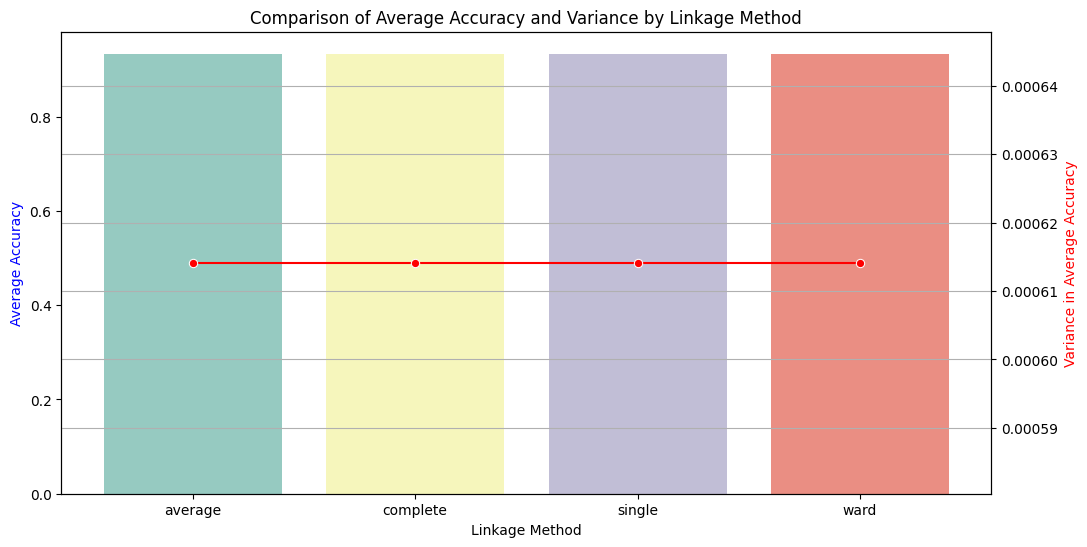

In [95]:
# Assuming 'result_df' has been updated to include an 'Average Accuracy' column after clustering
data = result_df
df = pd.DataFrame(data)

# Filter out the invalid average accuracies (if any)
df = df[df["Average Accuracy"].notnull()]

# Group by Linkage Method and calculate the mean and variance of Average Accuracies
aggregated_df = df.groupby("Linkage Method").agg({"Average Accuracy": ["mean", "var"]}).reset_index()
aggregated_df.columns = ["Linkage Method", "Average Accuracy_mean", "Average Accuracy_variance"]

# Plotting a combined plot for average accuracy and variance comparison by linkage method
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the average accuracies
sns.barplot(x='Linkage Method', y='Average Accuracy_mean', data=aggregated_df, palette="Set3", ax=ax1)
ax1.set_xlabel('Linkage Method')
ax1.set_ylabel('Average Accuracy', color='blue')
ax1.set_title('Comparison of Average Accuracy and Variance by Linkage Method')

# Adding the variance as a line plot with a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(x='Linkage Method', y='Average Accuracy_variance', data=aggregated_df, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Variance in Average Accuracy', color='red')

plt.grid(True)
plt.show()


In [91]:
result_df1 = process_clustering(full_results.copy())

In [92]:
result_df1.head()

,Seed,Linkage Method,Cluster Color Percentage,Silhouette Score,Maximum Color Separation
0,0,single,"{1: {'green': '93.5%', 'red': '6.5%'}, 2: {'gr...",0.730401,93.50
1,0,complete,"{1: {'green': '93.5%', 'red': '6.5%'}, 2: {'gr...",0.730401,93.50
2,0,average,"{1: {'green': '93.5%', 'red': '6.5%'}, 2: {'gr...",0.730401,93.50
3,0,ward,"{1: {'green': '93.5%', 'red': '6.5%'}, 2: {'gr...",0.730401,93.50
4,1,single,"{1: {'green': '87.31%', 'red': '12.69%'}, 2: {...",0.476111,81.39


Linkage Method: single
Color Distributions in Each Cluster:
Empty DataFrame
Columns: []
Index: []




C:\Users\taodz\AppData\Local\Temp\ipykernel_17716\4164602883.py:57: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  color_counts_per_cluster = df.groupby('Cluster')['Colors'].apply(lambda colors: pd.Series([color for sublist in colors for color in sublist]).value_counts())
C:\Users\taodz\AppData\Local\Temp\ipykernel_17716\4164602883.py:57: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  color_counts_per_cluster = df.groupby('Cluster')['Colors'].apply(lambda colors: pd.Series([color for sublist in colors for color in sublist]).value_counts())


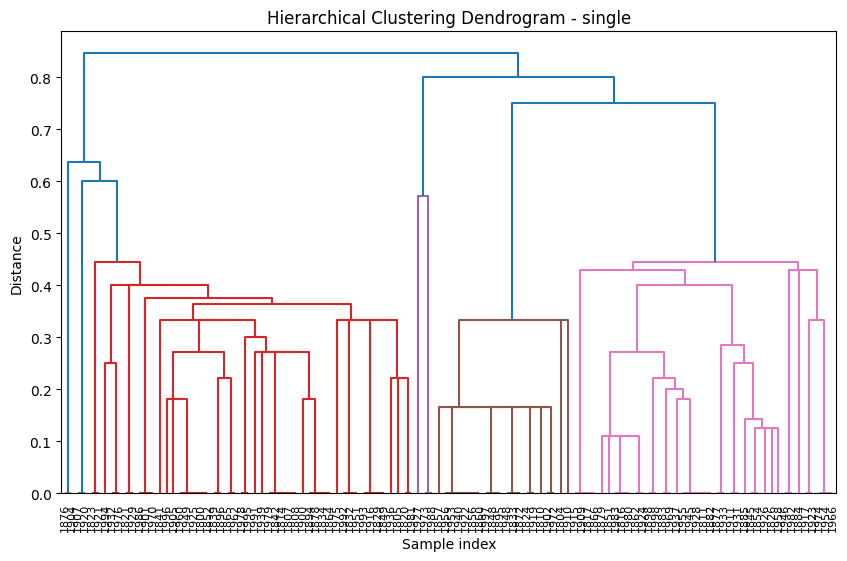

Linkage Method: complete
Color Distributions in Each Cluster:
Empty DataFrame
Columns: []
Index: []




C:\Users\taodz\AppData\Local\Temp\ipykernel_17716\4164602883.py:57: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  color_counts_per_cluster = df.groupby('Cluster')['Colors'].apply(lambda colors: pd.Series([color for sublist in colors for color in sublist]).value_counts())


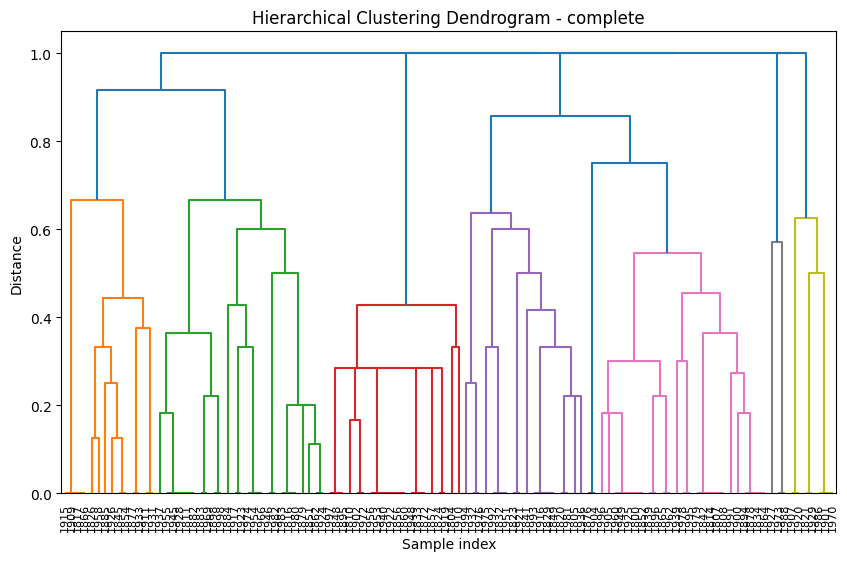

Linkage Method: average
Color Distributions in Each Cluster:
Empty DataFrame
Columns: []
Index: []




C:\Users\taodz\AppData\Local\Temp\ipykernel_17716\4164602883.py:57: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  color_counts_per_cluster = df.groupby('Cluster')['Colors'].apply(lambda colors: pd.Series([color for sublist in colors for color in sublist]).value_counts())
C:\Users\taodz\AppData\Local\Temp\ipykernel_17716\4164602883.py:57: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  color_counts_per_cluster = df.groupby('Cluster')['Colors'].apply(lambda colors: pd.Series([color for sublist in colors for color in sublist]).value_counts())


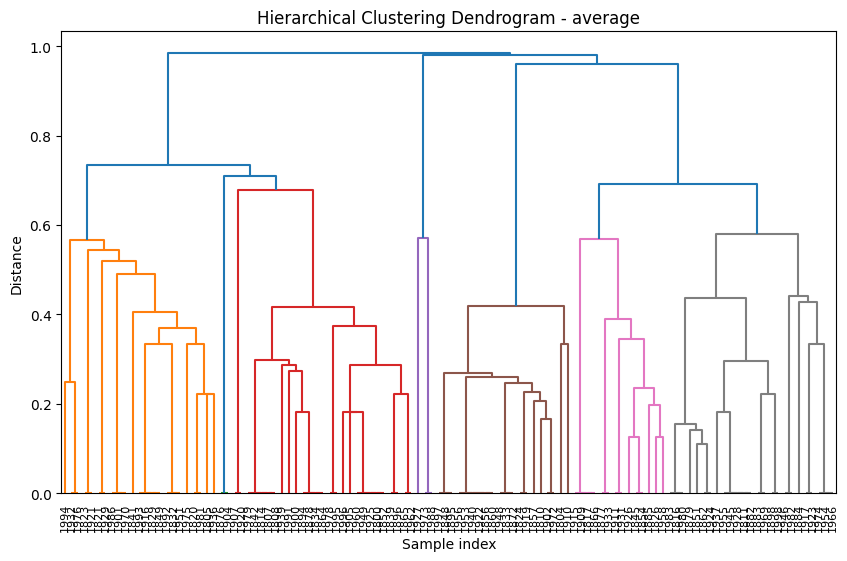

Linkage Method: ward
Color Distributions in Each Cluster:
Empty DataFrame
Columns: []
Index: []




C:\Users\taodz\AppData\Local\Temp\ipykernel_17716\4164602883.py:57: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  color_counts_per_cluster = df.groupby('Cluster')['Colors'].apply(lambda colors: pd.Series([color for sublist in colors for color in sublist]).value_counts())
C:\Users\taodz\AppData\Local\Temp\ipykernel_17716\4164602883.py:57: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  color_counts_per_cluster = df.groupby('Cluster')['Colors'].apply(lambda colors: pd.Series([color for sublist in colors for color in sublist]).value_counts())


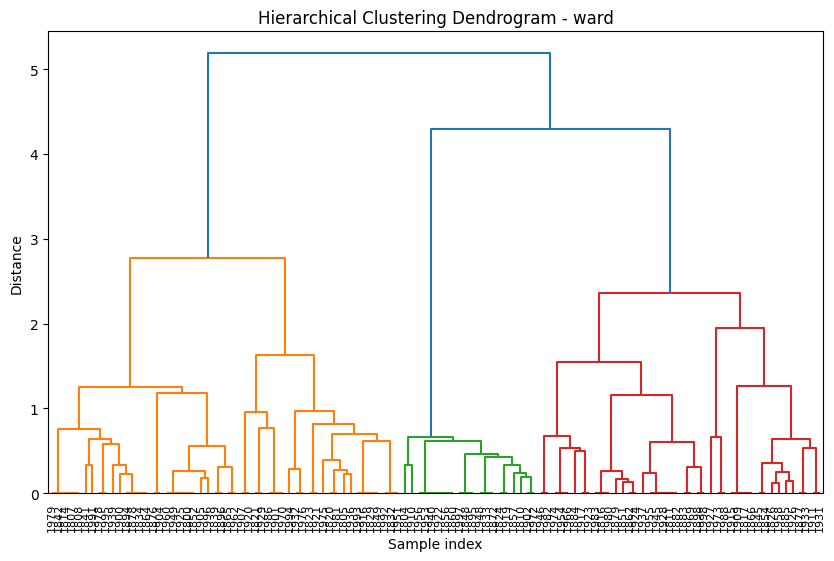

  Linkage Method Distance Metric  Number of Clusters  \
0         single         Jaccard                   2   
1       complete         Jaccard                   2   
2        average         Jaccard                   2   
3           ward         Jaccard                   2   

  Color Distribution Summary  
0                         {}  
1                         {}  
2                         {}  
3                         {}  


In [210]:
# Load the dataset
df = clusters_data.copy()

# Convert paths to sets of nodes
df['Path_Set'] = df['Path'].apply(lambda x: set(x))

# Calculate the Jaccard distance matrix
def jaccard_distance(set1, set2):
    if len(set1.union(set2)) == 0:
        return 0
    return 1 - len(set1.intersection(set2)) / len(set1.union(set2))

# Generate the distance matrix
n = len(df)
distance_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        distance_matrix[i, j] = jaccard_distance(df.iloc[i]['Path_Set'], df.iloc[j]['Path_Set'])
        distance_matrix[j, i] = distance_matrix[i, j]

# Convert the distance matrix to a format suitable for linkage
distance_matrix_condensed = squareform(distance_matrix)

# Define a function to perform clustering with different parameters
def hierarchical_clustering(distance_matrix, linkage_method='complete', n_clusters=3):
    # Perform hierarchical clustering
    Z = linkage(distance_matrix, method=linkage_method)
    
    # Cut the dendrogram at a specific level to form clusters
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    
    return Z, clusters

# Experiment with different hyperparameters
linkage_methods = ['single', 'complete', 'average', 'ward']
n_clusters = 2

results = []

for linkage_method in linkage_methods:
    print(f"Linkage Method: {linkage_method}")
    Z, clusters = hierarchical_clustering(distance_matrix_condensed, linkage_method, n_clusters)
    
    # Assign cluster labels to the original dataframe
    df['Cluster'] = clusters

    # Color mapping dictionary
    color_mapping = color_mapping

    # Extract color information for each path
    def extract_colors(path):
        return [color_mapping[int(node)] for node in path if int(node) in color_mapping]

    df['Colors'] = df['Path'].apply(extract_colors)

    # Count color occurrences in each cluster
    color_counts_per_cluster = df.groupby('Cluster')['Colors'].apply(lambda colors: pd.Series([color for sublist in colors for color in sublist]).value_counts())

    # Create a DataFrame to display the color distributions in each cluster
    color_distribution_df = color_counts_per_cluster.unstack().fillna(0).astype(int)
    
    # Create a summary string for color distributions
    color_distribution_summary = color_distribution_df.apply(lambda x: x.to_dict(), axis=1).to_dict()
    
    results.append({
        'Linkage Method': linkage_method,
        'Distance Metric': 'Jaccard',
        'Number of Clusters': n_clusters,
        'Color Distribution Summary': color_distribution_summary
    })
    
    print("Color Distributions in Each Cluster:")
    print(color_distribution_df)
    print("\n")

    # Optionally, visualize the clusters
    plt.figure(figsize=(10, 6))
    plt.title(f'Hierarchical Clustering Dendrogram - {linkage_method}')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    dendrogram(Z, leaf_rotation=90., leaf_font_size=8., labels=df.index)
    plt.show()

# Create a DataFrame to display the comparison table
comparison_table = pd.DataFrame(results)

# Display the comparison table
print(comparison_table)


In [ ]:
comparison_table 

In [86]:
comparison_table.to_csv('Comparison_table_06.csv')

In [23]:
cwd=os.getcwd()
cwd

'C:\\Users\\taodz\\Desktop\\PhD_Preferences_2022'

In [4]:
def generate_colored_graph(num_nodes, colors, edge_probability, node_color_seed, edge_seed):
    G = nx.Graph()
    random.seed(node_color_seed)
    edge_random = random.Random(edge_seed)
    shapes = ['circle', 'square', 'triangle']
    shininess_options = ['shiny', 'not_shiny']

    for i in range(1, num_nodes + 1):
        color = random.choice(colors)
        shape = random.choice(shapes)
        shininess = random.choice(shininess_options)
        G.add_node(i, color=color, shape=shape, shiny=shininess)

    for i in range(1, num_nodes + 1):
        for j in range(i + 1, num_nodes + 1):
            if random.random() < edge_probability:
                G.add_edge(i, j)

    return G

def plot_colored_graph(G):
    pos = nx.spring_layout(G, seed=42)
    colors = [G.nodes[node]['color'] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=500)
    nx.draw_networkx_edges(G, pos)
    plt.axis('off')
    plt.show()

def map_nodes_to_colors(path, color_mapping):
    return [color_mapping[node] for node in path]

def simulate_agents(graph, num_agents, num_traversals, seed, edge_probability):
    agent_data = []
    color_mapping = {node: graph.nodes[node]['color'] for node in graph.nodes()}  # Create color mapping for this graph

    for _ in range(num_traversals):
        for _ in range(num_agents):
            start_node = random.choice(list(graph.nodes()))
            end_node = random.choice(list(graph.nodes()))
            color_preference = random.choice(['red', 'green'])
            if graph.nodes[start_node]['color'] != graph.nodes[end_node]['color']:
                continue
            agent = Agent(start_node, end_node, color_preference)
            path, preferred_color_count = agent.traverse_graph(graph)
            agent_data.append({
                'Seed': seed,
                'Agent': _,
                'Start Node': start_node,
                'End Node': end_node,
                'Color Preference': color_preference,
                'Path Length': len(path),
                'Preferred Color Count': preferred_color_count,
                'Path': path,
                'Mapped Colors': map_nodes_to_colors(path, color_mapping),
                'Visited Shapes': agent.visited_shapes,
                'Visited Shininess': agent.visited_shininess,
                'Density': edge_probability
            })
    return pd.DataFrame(agent_data)

# ********************************************************************************
def check_graph_connected(G):
    """Check if all nodes in the graph are connected."""
    return nx.is_connected(G)

def plot_connected_vs_density(edge_probabilities, connectivity_results):
    """Plot a graph of connectivity percentage vs. density (edge probability)."""
    plt.plot(edge_probabilities, connectivity_results, marker='o', linestyle='-', color='b')
    plt.xlabel('Edge Probability (Density)')
    plt.ylabel('Percentage of Connected Graphs')
    plt.title('Connected vs. Density')
    plt.grid(True)
    plt.show()
    
def calculate_average_path_length(G):
    """Calculate the average path length if the graph is connected."""
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        return None

def plot_avg_path_length_vs_density(edge_probabilities, avg_path_lengths):
    """Plot a graph of average path length vs. density (edge probability)."""
    plt.plot(edge_probabilities, avg_path_lengths, marker='o', linestyle='-', color='g')
    plt.xlabel('Edge Probability (Density)')
    plt.ylabel('Average Path Length')
    plt.title('Average Path Length vs. Density')
    plt.grid(True)
    plt.show()
    
# **************************************************************************************
   
num_nodes = 100
colors = ['red', 'green']
# edge_probabilities = [0.05, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
edge_probabilities=0.12
connectivity_results = []
results = []
average_path_lengths = []

# Track connectivity for each edge probability
for edge_probability in edge_probabilities: # Iterate over edge probabilities
    connected_count = 0
    total_path_length = 0
    connected_graphs = 0
    
    for seed in range(50):  # Iterate over 50 seeds for each density
        G = generate_colored_graph(num_nodes, colors, edge_probability, seed, seed + 1000)
        plot_colored_graph(G)
        df_agents = simulate_agents(G, 5, 10, seed, edge_probability)  # Simulate 5 agents, 10 traversals
        results.append(df_agents)
        
        # Check if the graph is connected
        if check_graph_connected(G):
            connected_count += 1
            
        # Calculate the average path length only if the graph is connected
        avg_path_length = calculate_average_path_length(G)
        if avg_path_length is not None:
            total_path_length += avg_path_length
            connected_graphs += 1
            
    # Calculate the average path length across connected graphs for this density
    if connected_graphs > 0:
        average_path_lengths.append(total_path_length / connected_graphs)
    else:
        average_path_lengths.append(None)  # No connected graphs for this density

    
    # Calculate percentage of connected graphs for this density
    connectivity_percentage = (connected_count / 50) * 100
    connectivity_results.append(connectivity_percentage)

# Plot the results
plot_connected_vs_density(edge_probabilities, connectivity_results) 
plot_avg_path_length_vs_density(edge_probabilities, average_path_lengths)

# Combine all results into a single DataFrame for analysis
full_results = pd.concat(results, ignore_index=True)
full_results = full_results[full_results['Start Node'] != full_results['End Node']]
print(full_results[['Seed', 'Agent', 'Density', 'Mapped Colors']].head())
    
# *******************************************************************************


TypeError: 'float' object is not iterable

In [ ]:
# Version 2- clustering on a single bit

In [ ]:
# def process_clustering_1(df, linkage_method='ward', n_clusters=2):
#     df['Path_Set'] = df['Path'].apply(lambda x: set(x))
    
#     def jaccard_distance(set1, set2):
#         if len(set1.union(set2)) == 0:
#             return 1  # Maximum distance if both sets are empty
#         return 1 - len(set1.intersection(set2)) / len(set1.union(set2))

#     results = []
#     all_groups = []  # List to hold all grouped DataFrames

#     for seed, group in df.groupby('Seed'):
#         group = group.copy()  # Work with a copy to avoid side effects

#         # Manually compute the distance matrix for sets
#         num_items = len(group)
#         distance_matrix = np.zeros((num_items, num_items))
        
#         for i in range(num_items):
#             for j in range(i + 1, num_items):
#                 dist = jaccard_distance(group.iloc[i]['Path_Set'], group.iloc[j]['Path_Set'])
#                 distance_matrix[i, j] = dist
#                 distance_matrix[j, i] = dist  # Symmetric

#         # Perform clustering using the specified linkage method
#         Z = linkage(squareform(distance_matrix), method=linkage_method)
#         clusters = fcluster(Z, t=n_clusters, criterion='maxclust')
#         group['Cluster'] = clusters 

#         # Calculate accuracy
#         group['Accuracy'] = group.apply(lambda row: row['Mapped Colors'].count(row['Color Preference']) / len(row['Mapped Colors']) if len(row['Mapped Colors']) > 0 else 0, axis=1)

#         # Explode Mapped Colors for individual color counting
#         exploded_group = group.explode('Mapped Colors')
#         exploded_group.rename(columns={'Mapped Colors': 'Flat Colors'}, inplace=True)

#         # Compute color counts per cluster
#         color_counts = exploded_group.groupby(['Cluster', 'Flat Colors']).size().unstack(fill_value=0)
#         color_percentages = color_counts.div(color_counts.sum(axis=1), axis=0).mul(100).round(2)

#         # Format color percentages for output
#         cluster_color_percentages = color_percentages.apply(lambda x: x.dropna().to_dict(), axis=1).to_dict()
#         formatted_cluster_color_percentages = {k: {color: f"{percent}%" for color, percent in v.items()} for k, v in cluster_color_percentages.items()}

#         # Calculate maximum color separation for each cluster
#         max_color_separation = color_percentages.apply(lambda x: max(x) - min(x) if len(x) > 1 else 0).max()

#         # Calculate the silhouette score if applicable
#         silhouette_avg = -1
#         if len(set(clusters)) > 1:
#             silhouette_avg = silhouette_score(distance_matrix, clusters, metric='precomputed')

#         # Calculate average accuracy per cluster
#         avg_accuracy = group['Accuracy'].mean()

#         results.append({
#             'Seed': seed,
#             'Linkage Method': linkage_method,
#             'Cluster Color Percentage': formatted_cluster_color_percentages,
#             'Silhouette Score': silhouette_avg,
#             'Maximum Color Separation': max_color_separation,
#             'Average Accuracy': avg_accuracy  # Store average accuracy for the clustering
#         })

#         # Append the processed group DataFrame to the list
#         all_groups.append(group)

#     # Concatenate all grouped DataFrames into one
#     full_group_df = pd.concat(all_groups, ignore_index=True)

#     # Return both the results and the full clustering dataset
#     return pd.DataFrame(results), full_group_df


In [ ]:
Version 1

In [ ]:
# def simulate_agents(graph, num_agents, num_traversals, seed):
#     agent_data = []
#     color_mapping = {node: graph.nodes[node]['color'] for node in graph.nodes()}  # Create color mapping for this graph

#     for _ in range(num_traversals):
#         for _ in range(num_agents):
#             start_node = random.choice(list(graph.nodes()))
#             end_node = random.choice(list(graph.nodes()))
#             color_preference = random.choice(['red', 'green'])
#             if graph.nodes[start_node]['color'] != graph.nodes[end_node]['color']:
#                 continue
#             agent = Agent(start_node, end_node, color_preference)
#             path, preferred_color_count = agent.traverse_graph(graph)
#             agent_data.append({
#                 'Seed': seed,
#                 'Agent': _,
#                 'Start Node': start_node,
#                 'End Node': end_node,
#                 'Color Preference': color_preference,
#                 'Path Length': len(path),
#                 'Preferred Color Count': preferred_color_count,
#                 'Path': path,
#                 'Mapped Colors': map_nodes_to_colors(path, color_mapping),
#                 'Visited Shapes': agent.visited_shapes,
#                 'Visited Shininess': agent.visited_shininess,
#                 'Density':edge_probability
#             })
#     return pd.DataFrame(agent_data)





# def generate_colored_graph(num_nodes, colors, edge_probability, node_color_seed, edge_seed):
#     G = nx.Graph()
#     random.seed(node_color_seed)
#     edge_random = random.Random(edge_seed)
#     shapes = ['circle', 'square', 'triangle']
#     shininess_options = ['shiny', 'not_shiny']

#     for i in range(1, num_nodes + 1):
#         color = random.choice(colors)
#         shape = random.choice(shapes)
#         shininess = random.choice(shininess_options)
#         G.add_node(i, color=color, shape=shape, shiny=shininess)

#     for i in range(1, num_nodes + 1):
#         for j in range(i + 1, num_nodes + 1):
#             if random.random() < edge_probability:
#                 G.add_edge(i, j)

#     return G

# def plot_colored_graph(G):
#     pos = nx.spring_layout(G, seed=42)
#     colors = [G.nodes[node]['color'] for node in G.nodes()]
#     nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=500)
#     nx.draw_networkx_edges(G, pos)
#     plt.axis('off')
#     plt.show()

# def map_nodes_to_colors(path, color_mapping):
#     return [color_mapping[node] for node in path]

# def simulate_agents(graph, num_agents, num_traversals, seed):
#     agent_data = []
#     color_mapping = {node: graph.nodes[node]['color'] for node in graph.nodes()}  # Create color mapping for this graph

#     for _ in range(num_traversals):
#         for _ in range(num_agents):
#             start_node = random.choice(list(graph.nodes()))
#             end_node = random.choice(list(graph.nodes()))
#             color_preference = random.choice(['red', 'green'])
#             if graph.nodes[start_node]['color'] != graph.nodes[end_node]['color']:
#                 continue
#             agent = Agent(start_node, end_node, color_preference)
#             path, preferred_color_count = agent.traverse_graph(graph)
#             agent_data.append({
#                 'Seed': seed,
#                 'Agent': _,
#                 'Start Node': start_node,
#                 'End Node': end_node,
#                 'Color Preference': color_preference,
#                 'Path Length': len(path),
#                 'Preferred Color Count': preferred_color_count,
#                 'Path': path,
#                 'Mapped Colors': map_nodes_to_colors(path, color_mapping),
#                 'Visited Shapes': agent.visited_shapes,
#                 'Visited Shininess': agent.visited_shininess,
#                 'Density':edge_probability
#             })
#     return pd.DataFrame(agent_data)


# results = []
# num_nodes = 40
# colors = ['red', 'green']
# edge_probability = 0.2 

# for seed in range(50):
#     G = generate_colored_graph(num_nodes, colors, edge_probability, seed, seed + 1000)
#     plot_colored_graph(G)
#     df_agents = simulate_agents(G, 5, 10, seed)  # Simulate 5 agents, 10 traversals
#     results.append(df_agents)

# # Combine all results into a single DataFrame for analysis
# full_results = pd.concat(results, ignore_index=True)
# full_results = full_results[full_results['Start Node'] != full_results['End Node']]
# print(full_results[['Seed', 'Agent', 'Mapped Colors']].head())
